#Machine Learning W2022
##Assignment 2: Neural Networks & CNN

### Name - Sagar Suman | Roll No. 2019197

### Question 1 - Backpropagation

Imports - 

In [1]:
from sklearn import datasets
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from operator import add
from scipy.special import expit
import math
from tqdm import tqdm
import pickle as pk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

MyNeuralNetwork Class implementation - (Part 1 to Part 4)


In [2]:
## Q1.py

class MyNeuralNetwork():
    """
    My implementation of a Neural Network Classifier.
    """

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']
 

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        """
        Initializing a new MyNeuralNetwork object

        Parameters
        ----------
        """
        
        # n_layers : int value specifying the number of layers
        self.n_layers = n_layers;
        
        #layer_sizes : integer array of size n_layers specifying the number of nodes in each layer
        self.layer_sizes = layer_sizes;

        #activation : string specifying the activation function to be used
                     #possible inputs: relu, sigmoid, linear, tanh
        self.activation = activation;

        #learning_rate : float value specifying the learning rate to be used
        self.learning_rate = learning_rate;

        #weight_init : string specifying the weight initialization function to be used
                      #possible inputs: zero, random, normal
        self.weight_init = weight_init;

        #batch_size : int value specifying the batch size to be used
        self.batch_size = batch_size;

        #num_epochs : int value specifying the number of epochs to be used
        self.num_epochs = num_epochs;

        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        pass

        # Extra variable for storing weights and bias-
        self.weight = {};
        self.bias = {};
        # For stroing train and val loss
        self.train_loss = [];
        self.val_loss = [];
        # For storing weights after 50 and 100 epochs
        self.first_weight = {};
        self.second_weight = {};

        # Sklearn models
        if(self.activation == "relu"):
          acti = "relu"
        elif(self.activation == "linear"):
          acti = "identity";
        elif(self.activation == "tanh"):
          acti = "tanh"
        else:
          acti = "logistic";
        # For first 50 epochs - 
        self.sklearn_model1 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation = acti,solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=50, learning_rate_init = 0.001, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1); 
        # For first 100 epochs - 
        self.sklearn_model2 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation = acti,solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.001, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1);
        




    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer
        """
        x_calc = np.copy(X);
        x_calc[x_calc < 0] = 0;
        return x_calc;


    def relu_grad(self, X):
        """
        Calculating the gradient of ReLU activation for a particular layer
        """
        x_calc = np.copy(X);
        x_calc[x_calc >= 0] = 1;
        x_calc[x_calc < 0] = 0;
        return x_calc;


    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer
        """
        x_calc = np.copy(X);
        x_calc = 1/(1 + np.exp(-x_calc));
        return x_calc;


    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer
        """
        x_calc = np.copy(X);
        x_calc = self.sigmoid(x_calc);
        x_calc = x_calc * (1 - x_calc);
        return x_calc;


    def linear(self, X):
        """
        Calculating the Linear activation for a particular layer
        """
        x_calc = np.copy(X);
        return x_calc;


    def linear_grad(self, X):
        """
        Calculating the gradient of Linear activation for a particular layer
        """
        x_calc = np.copy(X);
        x_calc = np.ones(x_calc.shape);
        return x_calc;


    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer
        """
        x_calc = np.copy(X);
        x_calc = np.tanh(x_calc);
        return x_calc;


    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer
        """
        x_calc = np.copy(X);
        x_calc = 1 - (np.tanh(x_calc)**(2));
        return x_calc;


    def softmax(self, X):
        """
        Calculating the Softmax activation for a particular layer
        """
        x_calc = np.copy(X);
        deno = np.sum(np.exp(x_calc));
        x_calc = np.exp(x_calc) / deno;
        return x_calc


    def softmax_grad(self, X):
        """
        Calculating the gradient of Softmax activation for a particular layer
        """
        # It will return the jacobian matrix- 
        x_calc = np.copy(X);
        soft_max = self.softmax(x_calc);
        x_calc  = np.ones((soft_max.size,soft_max.size));
        for i in range(0,soft_max.size):
          x_calc[:,i] = x_calc[:,i]*soft_max[i];
          x_calc[i,:] = - x_calc[i,:]*soft_max[i];
          x_calc[i,i] =  soft_max[i]*(1 - soft_max[i]);
        
        return x_calc; 


    def zero_init(self, shape):
        """
        Calculating the initial weights after Zero Activation for a particular layer
        """
        weight = np.zeros(shape);
        return weight;


    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer
        """
        weight = np.random.rand(shape[0],shape[1]);
        weight = 2*(weight - 0.5);
        # As scaling factor is 0.01
        return weight * 0.01;


    def normal_init(self, shape):
        """
        Calculating the initial weights after Normal(0,1) Activation for a particular layer
        """
        weight = np.random.normal(size = shape);
        # As scaling factor is 0.01
        return weight * 0.01;

    #---------------------------------------------------------------
    # HELPER FUNCTIONS DEFINITIONS - 

    def cross_entropy_loss(self, X, y):
        """ 
        Calculates and return cross entropy loss
        """
        #print(X.shape)
        # as we have our loss function as cross entropy, and we might
        # get inf on 0, so applying softmax on last layer - 
        X = self.softmax(X);
        return -np.sum(np.log(X.T.dot(y)));        

    def one_hot_encoding(self,y):
      yy = np.zeros(10);
      yy[y] = 1;
      return yy.reshape(10,1);


    def Weight_initialize(self):
      """
      For intializing weights and bias
      """
      weight = {};
      bias = {};

      for i in range(self.n_layers-1):
        # For all layers - 
        # Weight have dimension = s(j+1) X s(j)
        if(self.weight_init == "zero"):
          weight[i] = self.zero_init((self.layer_sizes[i+1],self.layer_sizes[i]));
        elif(self.weight_init == "random"):
          weight[i] = self.random_init((self.layer_sizes[i+1],self.layer_sizes[i]));
        else:
          weight[i] = self.normal_init((self.layer_sizes[i+1],self.layer_sizes[i]));

        # As bias is set to zero  - 
        bias[i] = self.zero_init((self.layer_sizes[i+1],1));
      
      self.weight = weight;
      self.bias = bias;



    def compute_activation(self, X):
      """
        Returns result of chosen activation function applied on X
      """
      if(self.activation == "relu"):
        return self.relu(X);
      elif(self.activation == "linear"):
        return self.linear(X);
      elif(self.activation == "tanh"):
        return self.tanh(X);
      elif(self.activation == "sigmoid"):
        return self.sigmoid(X);
      else:
        return self.softmax(X);


    def compute_grad(self,X):
      """
        Returns result of Gradient of chosen activation function applied on X
      """
      if(self.activation == "relu"):
        return self.relu_grad(X);
      elif(self.activation == "linear"):
        return self.linear_grad(X);
      elif(self.activation == "tanh"):
        return self.tanh_grad(X);
      elif(self.activation == "sigmoid"):
        return self.sigmoid_grad(X);
      else:
        return self.softmax_grad(X);


    def forward_pass(self, x):
      """
        This functions is for computing forward pass 

        It returns two things - Z and A
        Z - is (W.T)x ( or inner product)
        A - is result of activation function applied on Z
      """
      Z = {};
      A = {};
      A[0]  = x
      # Starting from second layer as first layer is input
      for i in range(1,self.n_layers):
        # Computing Z- 
        Z[i] = self.weight[i-1].dot(A[i-1]) + self.bias[i-1];
        # Computing A -
        A[i] = self.compute_activation(Z[i]);

      return Z,A;
      

    def back_prop(self,y,A,Z):
      """
        This function is for computing back propagation
        It returns del
        delta - is used for computing gradient- 
      """  
      delta = {};
      delta[self.n_layers-1] = A[self.n_layers - 1] - y;
      # For calculating rest - loop in backward
      for i in range(self.n_layers-2,0,-1):
        delta[i] = (self.weight[i].T).dot(delta[i+1]);
        delta[i] = delta[i]*self.compute_grad(Z[i]);
      
      return delta;

    
    # OTHER Helper functions - 
    def plot_test_val_loss(self):
      """ 
      PLOTS Train and validation scores
      """
      plt.plot(self.train_loss,label = "Training Loss");
      plt.plot(self.val_loss,label = "Validation Loss");
      plt.legend();
      title = "MyNeuralNetwork Training and Validation Loss for "+self.activation;
      plt.title(title);


    def give_acc_fifty_epoch(self,X,y):
      """ 
      This function gives accuracy for X for saved weights 
      """
      # For first 50 and 100 epochs - 
      X = np.asarray(X);
      for i in range(X.shape[0]):
        Z1 = {};
        Z2 = {};
        A1 = {};
        A2 = {};
        A1[0] = X[i,:].reshape(X[i,:].size,1);
        A2[0] = X[i,:].reshape(X[i,:].size,1);
        # Starting from second layer as first layer is input
        for j in range(1,self.n_layers):
          # Computing Z- 
          Z1[j] = self.first_weight[j-1].dot(A1[j-1]);
          Z2[j] = self.second_weight[j-1].dot(A2[j-1]);
          # Computing A -
          A1[j] = self.compute_activation(Z1[j]);
          A2[j] = self.compute_activation(Z2[j]);

        # Applying Soft-Max for probablities on last layer- 
        probability1 = self.softmax(A1[self.n_layers-1].T);
        probability2 = self.softmax(A2[self.n_layers-1].T);
        if(i == 0):
           yy1 = probability1;
           yy2 = probability2;
        else:
           yy1 = np.vstack([yy1,probability1]);
           yy2 = np.vstack([yy2,probability2]);
      yy1 = yy1.argmax(axis = 1);
      yy2 = yy2.argmax(axis = 1);
      accuracy1 = np.sum(yy1 == y)/len(y)
      accuracy2 = np.sum(yy2 == y)/len(y)
      print("MyNeuralNetwork Accuracy after 50 epoch for ",self.activation,":",accuracy1);
      print("MyNeuralNetwork Accuracy after 100 epoch for",self.activation,":",accuracy2);




    #--------------------------------------------------------------

    # Change made in this function defintion - added X_val and y_val as parameter
    def fit(self, X, y, X_val = None, y_val = None):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.
        
        Returns
        -------
        self : an instance of self
        """

        # Intilializing weights - 
        self.Weight_initialize();

        index = list(range(X.shape[0]));
        train_loss = [];
        val_loss = [];
        # For all epochs - 
        for epoch in range(self.num_epochs):
          # For all batches -
          
          # RANDOM SHUFFLING 
          np.random.shuffle(index);
          train_loss_batch = 0;

          for batch in index:
            X_batch = np.copy(X[batch:batch+self.batch_size,:]);
            y_batch = np.copy(y[batch:batch+self.batch_size])
            
            #One hot encoding y - 
            y_batch = self.one_hot_encoding(y_batch);
            # Forwad pass -
            Z, A  = self.forward_pass(X_batch.T);
            # Backward propagation - 

            delta = self.back_prop(y_batch,A,Z);

            # Computing loss -
            train_loss_batch += self.cross_entropy_loss(A[self.n_layers-1],y_batch);

            # Gradient update - 
            Big_delta = {};
            for i in range(0,self.n_layers-1):
              Big_delta[i] = (delta[i+1].dot(A[i].T))/len(X_batch);
              #Updating weight and biases
              self.weight[i] = self.weight[i] - (self.learning_rate * Big_delta[i]);
              #self.bias[i]=self.bias[i]-self.learning_rate*np.sum(delta[i+1],axis=0)/len(X_batch)

          if(X_val is not None):
            # Training loss - 
            train_loss.append(train_loss_batch/len(y));

            X_val = np.asarray(X_val);
            y_val = np.asarray(y_val);
            # validation score - 
            val_loss_batch = 0;
            # Forward pass on X_val - 
            for i in range(X_val.shape[0]):
              Z,A = self.forward_pass(X_val[i,:].reshape(X_val[i,:].size,1));
              #Loss - 
              val_loss_batch += self.cross_entropy_loss(A[self.n_layers-1], self.one_hot_encoding(y_val[i]));
            
            #Append in validation loss
            val_loss.append(val_loss_batch/y_val.size);
            if((epoch+1)%5 == 0):
              print("Epoch:",(epoch+1),"Training_loss=",train_loss[len(train_loss)-1],"Validation_Loss=",val_loss[len(val_loss)-1]);
            # Saving weights for first and second 50th epochs - 
            if(epoch == 49):
              self.first_weight = self.weight.copy();
              self.first_bias = self.bias.copy();
            if(epoch == 99):
              self.second_weight = self.weight.copy();
              self.second_bias = self.bias.copy();
        
        self.train_loss = train_loss;
        self.val_loss = val_loss;


        # fit function has to return an instance of itself or else it won't work with test.py
        return self



    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.
        """
        X = np.asarray(X);
        for i in range(X.shape[0]):
              Z,A = self.forward_pass(X[i,:].reshape(X[i,:].size,1));
              # Applying Soft-Max for probablities on last layer- 
              probability = self.softmax(A[self.n_layers-1].T);
              if(i == 0):
                y = probability;
              else:
                y = np.vstack([y,probability]);
        # return the numpy array y which contains the probab of predicted values
        return y;


    def predict(self, X):
        """
        Predicting values using the trained linear model.
        """
        y = self.predict_proba(X);
        # return the numpy array y which contains the predicted values
        return y.argmax(axis = 1);


    def score(self, X, y):
        """
        Predicting values using the trained linear model.
        """
        y2 = self.predict(X)
        # return the ACcuracy
        accuracy = np.sum(y2 == y)/len(y)
        return accuracy;



#---------------------------SKLEARN ------------------------------------------


    def train_sklearn_models(self,X,y):
      #Fitting models - 
      self.sklearn_model1.fit(X,y);
      self.sklearn_model2.fit(X,y);



    def compare_with_mlp(self):
        loss_from_sklearn = self.sklearn_model2.loss_curve_
        plt.plot(loss_from_sklearn,label="sklearn")
        plt.plot(self.train_loss,label="MyNeuralNetwork")
        plt.legend();
        title = "Loss from sklearn vs MyNeuralNetwork for "+self.activation
        plt.title(title);


    def sklearm_acc_fifty_epoch(self,X,y):
      y1 = self.model1.predict(X);
      y2 = self.model2.predict(X);
      # return the ACcuracy
      accuracy1 = np.sum(y1 == y)/len(y)
      accuracy2 = np.sum(y2 == y)/len(y)
      print("MyNeuralNetwork Accuracy after 50 epoch for ",self.activation,":",accuracy1);
      print("MyNeuralNetwork Accuracy after 100 epoch for",self.activation,":",accuracy2);



#----------------END OF MyNeuralNetwork Class---------------------------------


For Question 1, part 5 -

In [3]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive');

Mounted at /content/gdrive


Reading FASHION MNIST dataset

In [4]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/fashion-mnist_train.csv')

In [5]:
data.shape

(60000, 785)

In [6]:
data.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


 Separating X and y

In [7]:
X = data.drop(columns = ['label']);
y = data['label'];
print(X.shape,y.shape);

(60000, 784) (60000,)


The dataSet has 10 classes -

In [8]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
print(pd.DataFrame(y).value_counts());

label
0        6000
1        6000
2        6000
3        6000
4        6000
5        6000
6        6000
7        6000
8        6000
9        6000
dtype: int64


Train/Validation Split - Splitting the dataset into 80%(training) 10%(validation) and 10%(validation)

In [10]:
#First splitting the dataset in to 80-20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20);

In [11]:
# Then splitting the 20% dataset into 10% 10%
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.50);

In [12]:
print(X_train.shape,X_val.shape,X_test.shape);

(48000, 784) (6000, 784) (6000, 784)


StandardScaler - 

In [13]:
scale = StandardScaler();
# Fitting and Transforming X_train
X_train = scale.fit_transform(X_train);
# Transforming X_test and X_val- 
X_test = scale.transform(X_test);
X_val = scale.transform(X_val);

Creating Models of implementaion of neural networks for following activation functions- 


*   ReLu
*   Sigmoid
*   Linear
*   Tanh





Training models - 

##ReLu

In [ ]:
NN_relu = MyNeuralNetwork(5,[784,256,128,64,10],'relu',0.1,'normal',1,100);

In [ ]:
NN_relu.fit(X_train,y_train, X_val, y_val);

Epoch: 5 Training_loss= 2.3025850951815348 Validation_Loss= 2.302584930856837
Epoch: 10 Training_loss= 2.302585024312609 Validation_Loss= 2.3025840000358144
Epoch: 15 Training_loss= 2.302585093053406 Validation_Loss= 2.3025850929938976
Epoch: 20 Training_loss= 2.302585093026357 Validation_Loss= 2.3025850929938976
Epoch: 25 Training_loss= 2.3025850930424125 Validation_Loss= 2.3025850929938976
Epoch: 30 Training_loss= 2.302585093062572 Validation_Loss= 2.3025850929938976
Epoch: 35 Training_loss= 2.302585092995473 Validation_Loss= 2.3025850929938976
Epoch: 40 Training_loss= 2.302585092995473 Validation_Loss= 2.3025850929938976
Epoch: 45 Training_loss= 2.302585092995473 Validation_Loss= 2.3025850929938976
Epoch: 50 Training_loss= 2.302585092995473 Validation_Loss= 2.3025850929938976
Epoch: 55 Training_loss= 2.302585092995473 Validation_Loss= 2.3025850929938976
Epoch: 60 Training_loss= 2.302585092995473 Validation_Loss= 2.3025850929938976
Epoch: 65 Training_loss= 2.302585092995473 Validatio

Dumping - 

In [ ]:
pk.dump(NN_relu,open("/content/gdrive/My Drive/Colab Notebooks/relu_NN.pkl","wb"))

For using Dumped model - 

In [22]:
NN_relu = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/relu_NN.pkl", 'rb'))
NN_relu.sklearn_model1 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/relu_sklearn_50.pkl", 'rb'))
NN_relu.sklearn_model2 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/relu_sklearn_100.pkl", 'rb'))
NN_relu2 =  pk.load(open("/content/gdrive/My Drive/Colab Notebooks/relu_NN001.pkl", 'rb'))

Plotting Training and validation loss curve for ReLu-

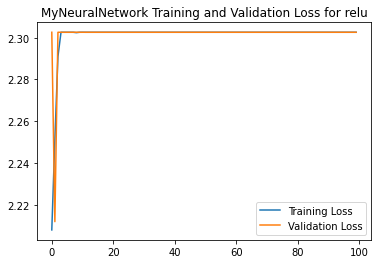

In [15]:
NN_relu.plot_test_val_loss();

Test Accuracy after 50 and 100 epochs for Relu

In [16]:
NN_relu.give_acc_fifty_epoch(X_test,y_test);

MyNeuralNetwork Accuracy after 50 epoch for  relu : 0.09683333333333333
MyNeuralNetwork Accuracy after 100 epoch for relu : 0.09683333333333333


## Now by using learning rate 0.001 on MyNeuralNetwork

In [ ]:
NN_relu2 = MyNeuralNetwork(5,[784,256,128,64,10],'relu',0.001,'normal',1,100);

In [ ]:
NN_relu2.fit(X_train,y_train, X_val, y_val);

Epoch: 5 Training_loss= 1.6612971671900407 Validation_Loss= 1.6475287464746382
Epoch: 10 Training_loss= 1.606845992897757 Validation_Loss= 1.6211321249693926
Epoch: 15 Training_loss= 1.5778879458758168 Validation_Loss= 1.6041710070574464
Epoch: 20 Training_loss= 1.5557125710264275 Validation_Loss= 1.5957038230552358
Epoch: 25 Training_loss= 1.5378945499495482 Validation_Loss= 1.5790634497896316
Epoch: 30 Training_loss= 1.5240025002526114 Validation_Loss= 1.582198104174703
Epoch: 35 Training_loss= 1.511850650105209 Validation_Loss= 1.576460106351362
Epoch: 40 Training_loss= 1.5026714378403143 Validation_Loss= 1.5893071280663955
Epoch: 45 Training_loss= 1.4932526970914899 Validation_Loss= 1.5822963661362812
Epoch: 50 Training_loss= 1.4874952660048144 Validation_Loss= 1.5874241789236023
Epoch: 55 Training_loss= 1.4828084239162724 Validation_Loss= 1.5788565023838754
Epoch: 60 Training_loss= 1.4784980157295895 Validation_Loss= 1.569857402299969
Epoch: 65 Training_loss= 1.475015238622349 Val

Dumping - 

In [17]:
pk.dump(NN_relu2,open("/content/gdrive/My Drive/Colab Notebooks/relu_NN001.pkl","wb"))

Plotting Training and validation loss curve for ReLu-

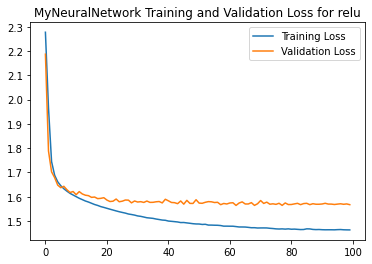

In [18]:
NN_relu2.plot_test_val_loss();

Test Accuracy after 50 and 100 epochs for Relu

In [19]:
NN_relu2.give_acc_fifty_epoch(X_test,y_test);

MyNeuralNetwork Accuracy after 50 epoch for  relu : 0.952
MyNeuralNetwork Accuracy after 100 epoch for relu : 0.978


##By using Sklearn for Relu activation

In [ ]:
NN_relu.train_sklearn_models(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Plotting graph of loss from Sklearn vs MyNeuralNetwork-

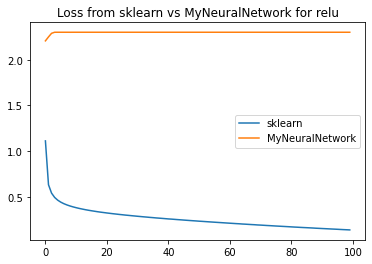

In [23]:
NN_relu.compare_with_mlp();

Printing Accuracy from Sklean and MyNeuralNetowek after fifty and 100 epochs-

In [24]:
NN_relu.give_acc_fifty_epoch(X_test,y_test);
y1 = NN_relu.sklearn_model1.predict(X_test);
y2 = NN_relu.sklearn_model2.predict(X_test);

accuracy1 = np.sum(y1 == y_test)/len(y_test)
accuracy2 = np.sum(y2 == y_test)/len(y_test)
print("Sklearn Accuracy after 50 epoch for Relu:",accuracy1);
print("Sklearn Accuracy after 100 epoch for Relu:",accuracy2);

MyNeuralNetwork Accuracy after 50 epoch for  relu : 0.09683333333333333
MyNeuralNetwork Accuracy after 100 epoch for relu : 0.09683333333333333
Sklearn Accuracy after 50 epoch for Relu: 0.9121666666666667
Sklearn Accuracy after 100 epoch for Relu: 0.9448333333333333


Dumping models - 

In [ ]:
pk.dump(NN_relu.sklearn_model1,open("/content/gdrive/My Drive/Colab Notebooks/relu_sklearn_50.pkl","wb"))
pk.dump(NN_relu.sklearn_model2,open("/content/gdrive/My Drive/Colab Notebooks/relu_sklearn_100.pkl","wb"))

##Tanh

In [ ]:
NN_tanh = MyNeuralNetwork(5,[784,256,128,64,10],'tanh',0.1,'normal',1,100);

In [ ]:
NN_tanh.fit(X_train,y_train, X_val, y_val);

Epoch: 5 Training_loss= 2.383590141001587 Validation_Loss= 2.372769689817952
Epoch: 10 Training_loss= 2.3767656776719015 Validation_Loss= 2.4121543344366567
Epoch: 15 Training_loss= 2.3653183159629516 Validation_Loss= 2.084107869930798
Epoch: 20 Training_loss= 2.347011930019407 Validation_Loss= 2.550038823947423
Epoch: 25 Training_loss= 2.3560260543211626 Validation_Loss= 2.546154746796892
Epoch: 30 Training_loss= 2.3489493152242993 Validation_Loss= 2.534583237407578
Epoch: 35 Training_loss= 2.3577750120336494 Validation_Loss= 2.456905547958083
Epoch: 40 Training_loss= 2.351936435521192 Validation_Loss= 2.407176672853677
Epoch: 45 Training_loss= 2.338137771244281 Validation_Loss= 2.081793551102086
Epoch: 50 Training_loss= 2.3612555514718796 Validation_Loss= 2.3854748218249666
Epoch: 55 Training_loss= 2.3644876133878405 Validation_Loss= 2.2071827684438565
Epoch: 60 Training_loss= 2.3515760681727835 Validation_Loss= 2.277738329601917
Epoch: 65 Training_loss= 2.3525878899145978 Validation

Dumping - 

In [ ]:
pk.dump(NN_tanh,open("/content/gdrive/My Drive/Colab Notebooks/tanh_NN.pkl","wb"))

For using Dumped model - 

In [25]:
NN_tanh = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/tanh_NN.pkl", 'rb'))
NN_tanh.sklearn_model1 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/tanh_sklearn_50.pkl", 'rb'))
NN_tanh.sklearn_model2 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/tanh_sklearn_100.pkl", 'rb'))
NN_tanh2 =  pk.load(open("/content/gdrive/My Drive/Colab Notebooks/tanh_NN001.pkl", 'rb'))

Plotting Training and validation loss curve for tanh-

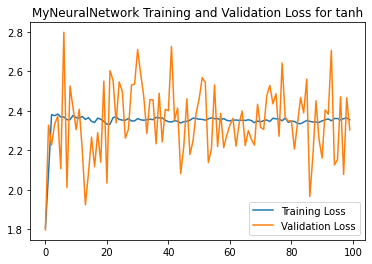

In [26]:
NN_tanh.plot_test_val_loss();

Test Accuracy after 50 and 100 epochs for tanh

In [27]:
NN_tanh.give_acc_fifty_epoch(X_test,y_test);

MyNeuralNetwork Accuracy after 50 epoch for  tanh : 0.07166666666666667
MyNeuralNetwork Accuracy after 100 epoch for tanh : 0.26033333333333336


## Now by using learning rate 0.001 on MyNeuralNetwork

In [ ]:
NN_tanh2 = MyNeuralNetwork(5,[784,256,128,64,10],'tanh',0.001,'normal',1,100);

In [ ]:
NN_tanh2.fit(X_train,y_train, X_val, y_val);

Epoch: 5 Training_loss= 1.7183920325951398 Validation_Loss= 1.7038846954080082
Epoch: 10 Training_loss= 1.6402978939721493 Validation_Loss= 1.647940204373707
Epoch: 15 Training_loss= 1.611290414896382 Validation_Loss= 1.619160221335958
Epoch: 20 Training_loss= 1.5900002336689099 Validation_Loss= 1.6076406522604485
Epoch: 25 Training_loss= 1.5716235817419375 Validation_Loss= 1.6056298847166663
Epoch: 30 Training_loss= 1.555020183870342 Validation_Loss= 1.5925114324921001
Epoch: 35 Training_loss= 1.540632171721036 Validation_Loss= 1.5829210394369841
Epoch: 40 Training_loss= 1.527606008093242 Validation_Loss= 1.584031817661411
Epoch: 45 Training_loss= 1.5160893709556558 Validation_Loss= 1.58403670831114
Epoch: 50 Training_loss= 1.506362564417804 Validation_Loss= 1.5779028796778518
Epoch: 55 Training_loss= 1.4978713771010321 Validation_Loss= 1.5793470435791817
Epoch: 60 Training_loss= 1.4920026277565637 Validation_Loss= 1.5712259069469312
Epoch: 65 Training_loss= 1.4865729839070077 Validat

Dumping - 

In [ ]:
pk.dump(NN_tanh2,open("/content/gdrive/My Drive/Colab Notebooks/tanh_NN001.pkl","wb"))

Plotting Training and validation loss curve for tanh-

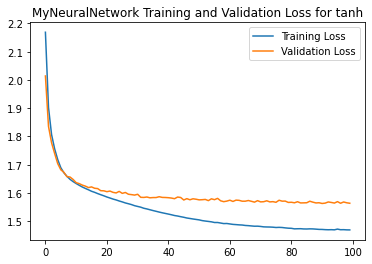

In [28]:
NN_tanh2.plot_test_val_loss();

Test Accuracy after 50 and 100 epochs for tanh

In [29]:
NN_tanh2.give_acc_fifty_epoch(X_test,y_test);

MyNeuralNetwork Accuracy after 50 epoch for  tanh : 0.9575
MyNeuralNetwork Accuracy after 100 epoch for tanh : 0.9733333333333334


##By using Sklearn for tanh activation

In [ ]:
NN_tanh.train_sklearn_models(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Plotting graph of loss from Sklearn vs MyNeuralNetwork-

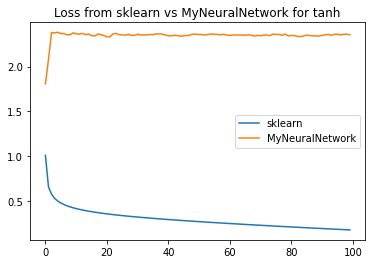

In [30]:
NN_tanh.compare_with_mlp();

Printing Accuracy from Sklean and MyNeuralNetowek after fifty and 100 epochs-

In [31]:
NN_tanh.give_acc_fifty_epoch(X_test,y_test);
y1 = NN_tanh.sklearn_model1.predict(X_test);
y2 = NN_tanh.sklearn_model2.predict(X_test);

accuracy1 = np.sum(y1 == y_test)/len(y_test)
accuracy2 = np.sum(y2 == y_test)/len(y_test)
print("Sklearn Accuracy after 50 epoch for tanh:",accuracy1);
print("Sklearn Accuracy after 100 epoch for tanh:",accuracy2);

MyNeuralNetwork Accuracy after 50 epoch for  tanh : 0.07166666666666667
MyNeuralNetwork Accuracy after 100 epoch for tanh : 0.26033333333333336
Sklearn Accuracy after 50 epoch for tanh: 0.9038333333333334
Sklearn Accuracy after 100 epoch for tanh: 0.9328333333333333


Dumping models - 

In [ ]:
pk.dump(NN_tanh.sklearn_model1,open("/content/gdrive/My Drive/Colab Notebooks/tanh_sklearn_50.pkl","wb"))
pk.dump(NN_tanh.sklearn_model2,open("/content/gdrive/My Drive/Colab Notebooks/tanh_sklearn_100.pkl","wb"))

##Sigmoid

In [ ]:
NN_sigmoid = MyNeuralNetwork(5,[784,256,128,64,10],'sigmoid',0.1,'normal',1,100);

In [ ]:
NN_sigmoid.fit(X_train,y_train, X_val, y_val);

Epoch: 5 Training_loss= 1.6637950214776904 Validation_Loss= 1.6618232724601527
Epoch: 10 Training_loss= 1.6395432956782006 Validation_Loss= 1.665867645218318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in exp


Epoch: 15 Training_loss= 1.6343727819084015 Validation_Loss= 1.6477648524961417
Epoch: 20 Training_loss= 1.6301737175755948 Validation_Loss= 1.6311827582911298
Epoch: 25 Training_loss= 1.6265119265960386 Validation_Loss= 1.634061101639506
Epoch: 30 Training_loss= 1.6264701568668685 Validation_Loss= 1.635335024726235
Epoch: 35 Training_loss= 1.6237282149389527 Validation_Loss= 1.6403316622604118
Epoch: 40 Training_loss= 1.6217463605604716 Validation_Loss= 1.6353572187880843
Epoch: 45 Training_loss= 1.6239386636778048 Validation_Loss= 1.6393591807486034
Epoch: 50 Training_loss= 1.6253832450357082 Validation_Loss= 1.6415095474007135
Epoch: 55 Training_loss= 1.6204590442888809 Validation_Loss= 1.629122720319953
Epoch: 60 Training_loss= 1.6194788000485836 Validation_Loss= 1.6320784608629828
Epoch: 65 Training_loss= 1.6210569628399307 Validation_Loss= 1.6337605635105226
Epoch: 70 Training_loss= 1.6208837951754327 Validation_Loss= 1.637789631319111
Epoch: 75 Training_loss= 1.6238304269524622 

Dumping - 

In [ ]:
pk.dump(NN_sigmoid,open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_NN.pkl","wb"))

For using Dumped model - 

In [32]:
NN_sigmoid = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_NN.pkl", 'rb'))
NN_sigmoid.sklearn_model1 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_sklearn_50.pkl", 'rb'))
NN_sigmoid.sklearn_model2 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_sklearn_100.pkl", 'rb'))
NN_sigmoid2 =  pk.load(open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_NN001.pkl", 'rb'))

Plotting Training and validation loss curve for Sigmoid-

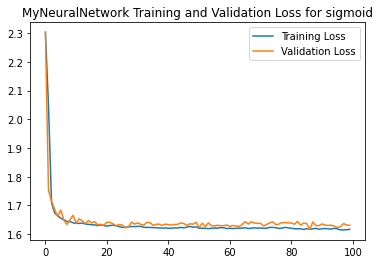

In [33]:
NN_sigmoid.plot_test_val_loss();

Test Accuracy after 50 and 100 epochs for Sigmoid

In [34]:
NN_sigmoid.give_acc_fifty_epoch(X_test,y_test);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in exp


MyNeuralNetwork Accuracy after 50 epoch for  sigmoid : 0.8686666666666667
MyNeuralNetwork Accuracy after 100 epoch for sigmoid : 0.879


## Now by using learning rate 0.001 on MyNeuralNetwork

In [ ]:
NN_sigmoid2 = MyNeuralNetwork(5,[784,256,128,64,10],'sigmoid',0.001,'normal',1,100);

In [ ]:
NN_sigmoid2.fit(X_train,y_train, X_val, y_val);

Epoch: 5 Training_loss= 2.3026158400014984 Validation_Loss= 2.3027142965769727
Epoch: 10 Training_loss= 2.3026331366271746 Validation_Loss= 2.302611191054555
Epoch: 15 Training_loss= 2.302621204322846 Validation_Loss= 2.302588053599102
Epoch: 20 Training_loss= 2.3013070905032245 Validation_Loss= 2.294808810571513
Epoch: 25 Training_loss= 2.0252397435898226 Validation_Loss= 2.0003709921279538
Epoch: 30 Training_loss= 1.851623436082876 Validation_Loss= 1.8368122373211746
Epoch: 35 Training_loss= 1.7606954256674234 Validation_Loss= 1.755687581897683
Epoch: 40 Training_loss= 1.6963284525621594 Validation_Loss= 1.6989575054378558
Epoch: 45 Training_loss= 1.6481520151540674 Validation_Loss= 1.6567777595032747
Epoch: 50 Training_loss= 1.6181271735638563 Validation_Loss= 1.6334656508639513
Epoch: 55 Training_loss= 1.5971870335931317 Validation_Loss= 1.6207260650113273
Epoch: 60 Training_loss= 1.5802593056514593 Validation_Loss= 1.6086851540217424
Epoch: 65 Training_loss= 1.564984132120602 Vali

Dumping - 

In [ ]:
pk.dump(NN_sigmoid2,open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_NN001.pkl","wb"))

Plotting Training and validation loss curve for Sigmoid-

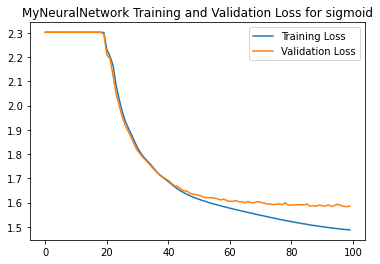

In [35]:
NN_sigmoid2.plot_test_val_loss();

Test Accuracy after 50 and 100 epochs for Sigmoid

In [36]:
NN_sigmoid2.give_acc_fifty_epoch(X_test,y_test);

MyNeuralNetwork Accuracy after 50 epoch for  sigmoid : 0.8945
MyNeuralNetwork Accuracy after 100 epoch for sigmoid : 0.9698333333333333


##By using Sklearn for Sigmoid activation

In [ ]:
NN_sigmoid.train_sklearn_models(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Plotting graph of loss from Sklearn vs MyNeuralNetwork-

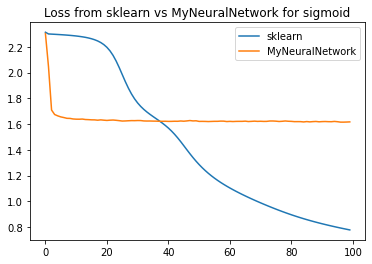

In [37]:
NN_sigmoid.compare_with_mlp();

Printing Accuracy from Sklean and MyNeuralNetowek after fifty and 100 epochs-

In [38]:
NN_sigmoid.give_acc_fifty_epoch(X_test,y_test);
y1 = NN_sigmoid.sklearn_model1.predict(X_test);
y2 = NN_sigmoid.sklearn_model2.predict(X_test);

accuracy1 = np.sum(y1 == y_test)/len(y_test)
accuracy2 = np.sum(y2 == y_test)/len(y_test)
print("Sklearn Accuracy after 50 epoch for Sigmoid:",accuracy1);
print("Sklearn Accuracy after 100 epoch for Sigmoid:",accuracy2);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in exp


MyNeuralNetwork Accuracy after 50 epoch for  sigmoid : 0.8686666666666667
MyNeuralNetwork Accuracy after 100 epoch for sigmoid : 0.879
Sklearn Accuracy after 50 epoch for Sigmoid: 0.553
Sklearn Accuracy after 100 epoch for Sigmoid: 0.7265


Dumping models - 

In [ ]:
pk.dump(NN_sigmoid.sklearn_model1,open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_sklearn_50.pkl","wb"))
pk.dump(NN_sigmoid.sklearn_model2,open("/content/gdrive/My Drive/Colab Notebooks/sigmoid_sklearn_100.pkl","wb"))

##Linear

In [ ]:
NN_linear = MyNeuralNetwork(5,[784,256,128,64,10],'linear',0.001,'normal',1,100);

In [ ]:
NN_linear.fit(X_train,y_train, X_val, y_val);

Epoch: 5 Training_loss= 1.8078639082823837 Validation_Loss= 1.8014897648918298
Epoch: 10 Training_loss= 1.7917825825914775 Validation_Loss= 1.7977189986839188
Epoch: 15 Training_loss= 1.789765755289461 Validation_Loss= 1.7969545355098495
Epoch: 20 Training_loss= 1.7892240468952727 Validation_Loss= 1.796584245703606
Epoch: 25 Training_loss= 1.7885510208659765 Validation_Loss= 1.789257954669905
Epoch: 30 Training_loss= 1.7881413554062147 Validation_Loss= 1.7988650703090212
Epoch: 35 Training_loss= 1.7879676653432828 Validation_Loss= 1.7889538549237558
Epoch: 40 Training_loss= 1.7874311354667 Validation_Loss= 1.8000071975058203
Epoch: 45 Training_loss= 1.7873766924688326 Validation_Loss= 1.7958884184617754
Epoch: 50 Training_loss= 1.7872640385521197 Validation_Loss= 1.7933104529250075
Epoch: 55 Training_loss= 1.7872746270062716 Validation_Loss= 1.7883071843003286
Epoch: 60 Training_loss= 1.7868408535800866 Validation_Loss= 1.7982505104089808
Epoch: 65 Training_loss= 1.7871957867933528 Val

Dumping - 

In [ ]:
pk.dump(NN_linear,open("/content/gdrive/My Drive/Colab Notebooks/linear_NN.pkl","wb"))

For using Dumped model - 

In [40]:
NN_linear = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/linear_NN.pkl", 'rb'))
NN_linear.sklearn_model1 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/linear_sklearn_50.pkl", 'rb'))
NN_linear.sklearn_model2 = pk.load(open("/content/gdrive/My Drive/Colab Notebooks/linear_sklearn_100.pkl", 'rb'))

Plotting Training and validation loss curve for Linear-

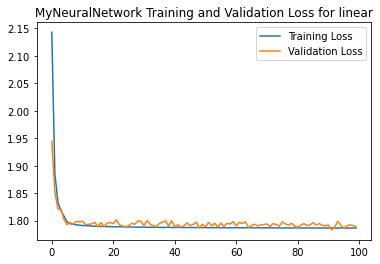

In [41]:
NN_linear.plot_test_val_loss();

Test Accuracy after 50 and 100 epochs for Linear

In [42]:
NN_linear.give_acc_fifty_epoch(X_test,y_test);

MyNeuralNetwork Accuracy after 50 epoch for  linear : 0.8196666666666667
MyNeuralNetwork Accuracy after 100 epoch for linear : 0.8183333333333334


##By using Sklearn for Linear activation

In [ ]:
NN_linear.train_sklearn_models(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Plotting graph of loss from Sklearn vs MyNeuralNetwork-

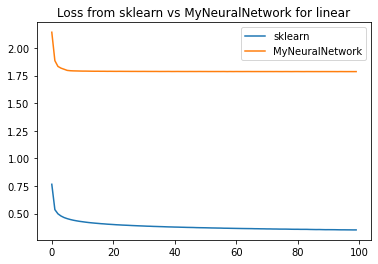

In [43]:
NN_linear.compare_with_mlp();

Printing Accuracy from Sklean and MyNeuralNetowek after fifty and 100 epochs-

In [44]:
NN_linear.give_acc_fifty_epoch(X_test,y_test);
y1 = NN_linear.sklearn_model1.predict(X_test);
y2 = NN_linear.sklearn_model2.predict(X_test);

accuracy1 = np.sum(y1 == y_test)/len(y_test)
accuracy2 = np.sum(y2 == y_test)/len(y_test)
print("Sklearn Accuracy after 50 epoch for linear:",accuracy1);
print("Sklearn Accuracy after 100 epoch for linear:",accuracy2);

MyNeuralNetwork Accuracy after 50 epoch for  linear : 0.8196666666666667
MyNeuralNetwork Accuracy after 100 epoch for linear : 0.8183333333333334
Sklearn Accuracy after 50 epoch for linear: 0.8666666666666667
Sklearn Accuracy after 100 epoch for linear: 0.8711666666666666


Dumping models - 

In [ ]:
pk.dump(NN_linear.sklearn_model1,open("/content/gdrive/My Drive/Colab Notebooks/linear_sklearn_50.pkl","wb"))
pk.dump(NN_linear.sklearn_model2,open("/content/gdrive/My Drive/Colab Notebooks/linear_sklearn_100.pkl","wb"))